# Sentimental analysis on Audio Data

## Libraries to import 

In [24]:
import numpy as np
import tensorflow as tf
import librosa

from tensorflow.keras.layers import ReLU,Input, LSTM, Conv2D, Conv1D, Bidirectional, Dropout, Dense, MaxPool2D, GlobalAvgPool3D, AvgPool2D, GlobalAvgPool2D, GlobalAvgPool1D, BatchNormalization, Concatenate, Reshape, Flatten
from tensorflow.keras import Sequential, Model
import os, math
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random
from skimage import io, color

tf.executing_eagerly()

True

Mount Drive to colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Here are steps for training

## Data preperation

Creating a function to extract mfcc data from audio file

In [ ]:
FolderPath = '/content/drive/MyDrive/intern_jul20/Audio_Speech_Actors_01-24'
json_path = '/content/drive/MyDrive/intern_jul20/data.json'

def Extract_files(FolderPath, n_mfcc = 40, n_fft = 2048, hop_length = 512):
    data = {
        'mapping' : ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise'],
        'mfcc' : [],
        'labels' : []
    }

    Data = {
        'mapping' : ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise'],
        'mfcc' : [],
        'labels' : []
    }

    s = 0
    for dirpath, dirnames, filenames in os.walk(FolderPath):
        if dirpath is not FolderPath:
            dirname  = dirpath.split('/')[-1]
            print('--------*****', dirname,'*****-------')

            for File in filenames:
                file_path = os.path.join(dirpath, File)
                label  = File.split('-')[2]

                SAMPLE_RATE = 22050
                signal, sr = librosa.load(file_path, sr = SAMPLE_RATE)

                DURATION = librosa.get_duration(y=signal, sr=sr)
                SAMPLES_PER_TRACK  = SAMPLE_RATE * DURATION
                
                num_segments = int(DURATION) # since the file is long

                #  here is the calcu of the no of samples per segment
                #  and
                # 

                start_sample = int(SAMPLES_PER_TRACK/num_segments)
                end_sample = int(SAMPLES_PER_TRACK - start_sample)

                mfcc  = librosa.feature.mfcc(signal[start_sample:end_sample],
                                                    sr = sr,
                                                    n_mfcc = n_mfcc,
                                                    n_fft = n_fft,
                                                    hop_length = hop_length)
                
                mfcc = mfcc.T
                mfcc = np.resize(mfcc, (224,224,3))
                data['mfcc'].append(mfcc)
                # Data['mfcc'].append(mfcc.tolist())
                data['labels'].append(int(label)-1)
                # Data['labels'].append(int(label)-1)
                s+=1
                print("no_sample:{} and the mfcc resized to:{}".format(s, mfcc.shape))
    return data

FolderPath = '/content/drive/MyDrive/intern_jul20/Audio_Speech_Actors_01-24'
json_path = '/content/drive/MyDrive/intern_jul20/data.json'

Data = Extract_files(FolderPath)

In [3]:
M = np.load('/content/drive/MyDrive/intern_jul20/data1.npy')
with open("/content/drive/MyDrive/intern_jul20/data1_label.json", "r") as read_file:
    LABELS = json.load(read_file)


LABELS1 = np.array(LABELS).reshape(-1,1)

num_2_onehot1 = OneHotEncoder()
y_onehot1= num_2_onehot1.fit_transform(LABELS1)

Y_onehot1=y_onehot1.toarray()

M.shape, Y_onehot1.shape

((1445, 224, 224, 3), (1445, 8))

In [4]:
x_train,x_val,y_train,y_val=train_test_split(M,Y_onehot1,test_size=.2,shuffle=True, random_state=42)

## Developing diffrent kinds of models

### CNN model developed using coustumized layers

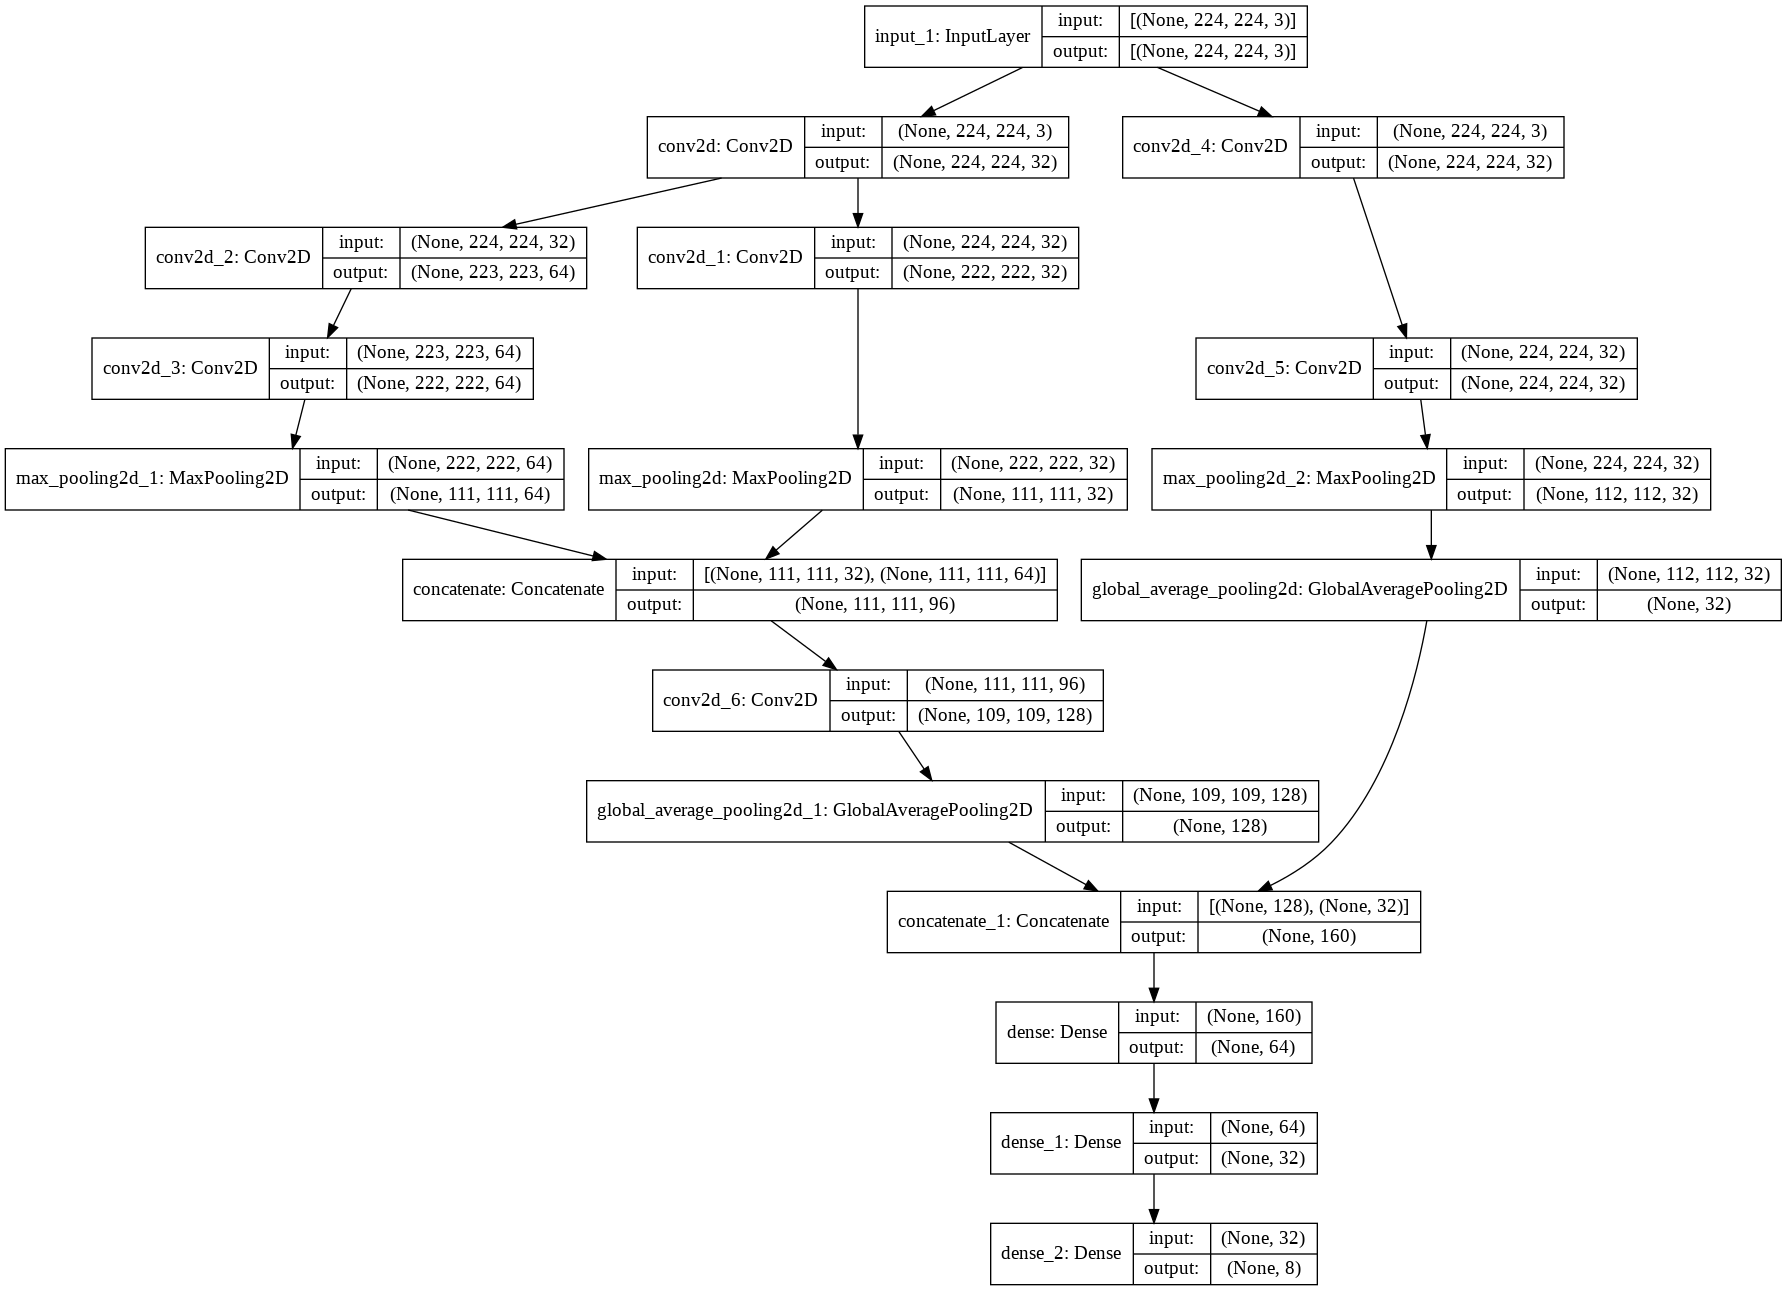

In [5]:
inp = Input(shape=(224,224,3))
layer1 = Conv2D(32,3, padding='same', activation='relu')(inp)



layer11 = Conv2D(32, 3, activation='relu')(layer1)
layer111 = MaxPool2D((2,2))(layer11)

layer12 = Conv2D(64, 2, activation='relu')(layer1)
layer121 = Conv2D(64, 2, activation='relu')(layer12)
layer1211 = MaxPool2D((2,2))(layer121)

layer2 = Conv2D(32,3, padding='same', activation='relu')(inp)
layer21 = Conv2D(32, 3, padding='same', activation='relu')(layer2)
layer211 = MaxPool2D((2,2))(layer21)
layer2111 = GlobalAvgPool2D()(layer211)

layer3 = Concatenate()([layer111, layer1211])
layer31 = Conv2D(128,3, activation='relu')(layer3)
layer311 = GlobalAvgPool2D()(layer31)

layer4 = Concatenate()([layer311, layer2111])
layer41 = Dense(64, activation='relu')(layer4)
layer411 = Dense(32, activation='relu')(layer41)
layer4111 = Dense(8, activation='softmax')(layer411)

model = Model(inp, layer4111)
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=75, batch_size=32, validation_data=(x_val, y_val), shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/75
37/37 [==============================] - 51s 391ms/step - loss: 4.5618 - accuracy: 0.1349 - val_loss: 2.1814 - val_accuracy: 0.1142
Epoch 2/75
37/37 [==============================] - 13s 341ms/step - loss: 2.1265 - accuracy: 0.1505 - val_loss: 2.1690 - val_accuracy: 0.1349
Epoch 3/75
37/37 [==============================] - 13s 348ms/step - loss: 2.0375 - accuracy: 0.2137 - val_loss: 2.1038 - val_accuracy: 0.1419
Epoch 4/75
37/37 [==============================] - 13s 356ms/step - loss: 2.0306 - accuracy: 0.2206 - val_loss: 1.9637 - val_accuracy: 0.1903
Epoch 5/75
37/37 [==============================] - 13s 365ms/step - loss: 1.9352 - accuracy: 0.2457 - val_loss: 1.9434 - val_accuracy: 0.2699
Epoch 6/75
37/37 [==============================] - 14s 372ms/step - loss: 1.9319 - accuracy: 0.2422 - val_loss: 1.9296 - val_accuracy: 0.2768
Epoch 7/75
37/37 [==============================] - 13s 364ms/step - loss: 1.8952 - accuracy: 0.2699 - val_loss: 2.0054 - val_accuracy: 0.2318

In [9]:
model.load_weights(checkpoint_filepath)
def get_accuracy(x_val = x_val, y_val = y_val):
    v = np.argmax(model.predict(x_val), axis=1)
    exp = np.argmax(y_val, axis=1)
    accr = np.sum(v==exp)/len(v)
    print("Here is the accuracy of the trained model on validation data : {:5.2f}%".format(accr*100))

get_accuracy()

Here is the accuracy of the trained model on validation data : 62.63%


In [10]:
model.save('/content/my_modeld_Aug_1_62.13.h5')

### LSTM model using sequential model

In [14]:
m = []
for i in M:
    m.append(np.resize(i, (54,44)))
m = np.array(m)
x_train,x_val,y_train,y_val=train_test_split(m,Y_onehot1,test_size=.2,shuffle=True, random_state=42)
for i in [x_train,x_val,y_train,y_val]:
    print(i.shape)

(1156, 54, 44)
(289, 54, 44)
(1156, 8)
(289, 8)


In [22]:
l1 = 148 #@param {type:'slider', min:100, max:200, step:4}
l2 = 112 #@param {type:'slider', min:100, max:200, step:4}
l3 = 100 #@param {type:'slider', min:40, max:200, step:4}
l4 = 64 #@param {type:'slider', min:40, max:200, step:4}
l5 = 100 #@param {type:'slider', min:40, max:200, step:4}

drop1 = 0.2 #@param {type:'slider', min:0, max:0.9, step:0.05}
drop2 = 0.1 #@param {type:'slider', min:0, max:0.9, step:0.05}


model2 = Sequential([
                    Input(shape=(54,44)),
                    LSTM(l1, return_sequences=True),
                    LSTM(l1, return_sequences=True),
                    LSTM(l2, return_sequences=True),
                    LSTM(l2, return_sequences=True),
                    Reshape((54,l2,1)),

                    Conv2D(32, 3, activation='relu'),
                    Dropout(drop1),
                    Conv2D(32, 3),
                    BatchNormalization(),
                    ReLU(),
                    MaxPool2D((2,2)),
                    
                    Reshape((25, 54 * 32)),
                    LSTM(l3, return_sequences=True),
                    LSTM(l4, return_sequences=True),
                    LSTM(l5),
                    Dropout(drop2),
                    Dense(32, 'relu'),
                    Dense(8, 'softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 54, 148)           114256    
_________________________________________________________________
lstm_18 (LSTM)               (None, 54, 148)           175824    
_________________________________________________________________
lstm_19 (LSTM)               (None, 54, 112)           116928    
_________________________________________________________________
lstm_20 (LSTM)               (None, 54, 112)           100800    
_________________________________________________________________
reshape_6 (Reshape)          (None, 54, 112, 1)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 52, 110, 32)       320       
_________________________________________________________________
dropout_5 (Dropout)          (None, 52, 110, 32)      

In [21]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(x_train, y_train, epochs=75, batch_size=32, validation_data=(x_val, y_val), shuffle=True, callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)
def get_accuracy(x_val = x_val, y_val = y_val):
    v = np.argmax(model2.predict(x_val), axis=1)
    exp = np.argmax(y_val, axis=1)
    accr = np.sum(v==exp)/len(v)
    print("Here is the accuracy of the trained model on validation data : {:5.2f}%".format(accr*100))

get_accuracy()

Epoch 1/75
37/37 [==============================] - 12s 96ms/step - loss: 2.0408 - accuracy: 0.1644 - val_loss: 2.0554 - val_accuracy: 0.1280
Epoch 2/75
37/37 [==============================] - 1s 40ms/step - loss: 1.9382 - accuracy: 0.2093 - val_loss: 1.9553 - val_accuracy: 0.2457
Epoch 3/75
37/37 [==============================] - 1s 41ms/step - loss: 1.8728 - accuracy: 0.2448 - val_loss: 1.8713 - val_accuracy: 0.2422
Epoch 4/75
37/37 [==============================] - 1s 40ms/step - loss: 1.7976 - accuracy: 0.2543 - val_loss: 1.9036 - val_accuracy: 0.2491
Epoch 5/75
37/37 [==============================] - 1s 40ms/step - loss: 1.8736 - accuracy: 0.2284 - val_loss: 1.8870 - val_accuracy: 0.1488
Epoch 6/75
37/37 [==============================] - 1s 40ms/step - loss: 1.7812 - accuracy: 0.2517 - val_loss: 1.9084 - val_accuracy: 0.2284
Epoch 7/75
37/37 [==============================] - 1s 40ms/step - loss: 1.7510 - accuracy: 0.2638 - val_loss: 1.8381 - val_accuracy: 0.2353
Epoch 8/75
3

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f2928cf1560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Here is the accuracy of the trained model on validation data : 35.29%


In [19]:
model2.save('/content/my_modeld_Aug_1_lstm_48.10.h5')

### CNN model using Sequential

In [28]:
l1 = 32 #@param {type:'slider', min:16, max:200, step:4}
l2 = 64 #@param {type:'slider', min:16, max:200, step:4}
l3 = 64 #@param {type:'slider', min:40, max:200, step:4}
l4 = 128 #@param {type:'slider', min:40, max:200, step:4}
d5 = 64 #@param {type:'slider', min:40, max:200, step:4}

drop1 = 0.2 #@param {type:'slider', min:0, max:0.9, step:0.05}

model3 = Sequential([
                    Input(shape=(54,44)),
                    Reshape((54,44,1)),
                    Conv2D(l1, 3, padding='same', activation='relu'),
                    Conv2D(l2, 3, activation='relu'),
                    MaxPool2D((2,2)),

                    Conv2D(l3, 3, activation='relu'),
                    Conv2D(l4, 3, activation='relu'),
                    MaxPool2D((2,2)),

                    GlobalAvgPool2D(),
                    Dropout(drop1),
                    Dense(d5, activation='relu'),
                    Dense(8, activation='softmax')

])

model3.summary()

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.fit(x_train, y_train, epochs=75, batch_size=32, validation_data=(x_val, y_val), shuffle=True, callbacks=[model_checkpoint_callback])

model3.load_weights(checkpoint_filepath)
def get_accuracy(x_val = x_val, y_val = y_val):
    v = np.argmax(model3.predict(x_val), axis=1)
    exp = np.argmax(y_val, axis=1)
    accr = np.sum(v==exp)/len(v)
    print("Here is the accuracy of the trained model on validation data : {:5.2f}%".format(accr*100))

get_accuracy()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 54, 44, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 54, 44, 32)        320       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 52, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 21, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 19, 64)        36928     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 22, 17, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 8, 128)       

In [29]:
model3.save('/content/my_modeld_Aug_1_cnn_66.44.h5')